<a href="https://colab.research.google.com/github/amuthalingeswaranbose/ECoNet/blob/main/econet_cotton_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install librarires

In [ ]:
!pip install fastbook

In [ ]:
!pip install fastai

# Import

In [ ]:
from pathlib import Path
from fastai.vision.widgets import *
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Check image dimension

In [ ]:
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

# Example usage:
image_path = '/content/drive/MyDrive/cotton_resized/Aphids/1.jpg'  # Replace with the path to your image
width, height = get_image_dimensions(image_path)

print(f"Image Dimensions: {width} x {height} pixels")


Image Dimensions: 224 x 224 pixels


# Create DataLoaders

In [ ]:
from fastai.vision.all import *

# Set your path to the directory containing the folders of images
path = Path('/content/drive/MyDrive/cotton_resized')

# Create DataLoaders
dls = ImageDataLoaders.from_folder(path,
                                   train='.',
                                   valid_pct=0.85,
                                   seed=42,
                                   item_tfms=[Resize(224)],
                                   batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)],
                                   bs=32)
                                    #bs=4
#                                     bs=64

In [ ]:
# Get the count of image samples in the train and valid datasets
train_count = len(dls.train.dataset)
valid_count = len(dls.valid.dataset)

print(f"Number of samples in the training dataset: {train_count}")
print(f"Number of samples in the validation dataset: {valid_count}")

Number of samples in the training dataset: 1337
Number of samples in the validation dataset: 7573


In [ ]:
# Assuming dls is your DataLoaders object
image_shape = dls.train_ds[0][0].shape
print(f"Train Image dimensions: {image_shape}")

Train Image dimensions: (224, 224)


In [ ]:
# Assuming dls is your DataLoaders object
image_shape = dls.valid_ds[0][0].shape
print(f"Train Image dimensions: {image_shape}")

Train Image dimensions: (224, 224)


In [ ]:
#class count
dls.c

8

In [ ]:
#batch size
dls.bs

32

# Coordinate covolution class

In [ ]:
# Import
import torch
import torch.nn as nn
import torch.nn.modules.conv as conv#conv
#pixel wise addcoords
#self- class member(identity)
#rank- sending argument
class AddCoords(nn.Module):
    def __init__(self, rank, with_r=False, use_cuda=True):
        super(AddCoords, self).__init__()
        self.rank = rank
        self.with_r = with_r
        self.use_cuda = use_cuda
#execution of cocnn
    def forward(self, input_tensor):
        """
        :param input_tensor: shape (N, C_in, H, W)
        :return:
        """
        if self.rank == 2:
            batch_size_shape, channel_in_shape, dim_y, dim_x = input_tensor.shape
            xx_ones = torch.ones([1, 1, 1, dim_x], dtype=torch.int32)
            yy_ones = torch.ones([1, 1, 1, dim_y], dtype=torch.int32)

            xx_range = torch.arange(dim_y, dtype=torch.int32)
            yy_range = torch.arange(dim_x, dtype=torch.int32)
            xx_range = xx_range[None, None, :, None]
            yy_range = yy_range[None, None, :, None]

            xx_channel = torch.matmul(xx_range, xx_ones)
            yy_channel = torch.matmul(yy_range, yy_ones)

            # transpose y
            yy_channel = yy_channel.permute(0, 1, 3, 2)

            xx_channel = xx_channel.float() / (dim_y - 1)
            yy_channel = yy_channel.float() / (dim_x - 1)

            xx_channel = xx_channel * 2 - 1
            yy_channel = yy_channel * 2 - 1

            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1, 1)
            yy_channel = yy_channel.repeat(batch_size_shape, 1, 1, 1)

            if torch.cuda.is_available and self.use_cuda:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
                yy_channel = yy_channel.cuda()
            out = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)

        else:
            raise NotImplementedError

        return out

class CoordConv2d(conv.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, groups, stride,
                 padding, dilation=1, bias=False, with_r=False, use_cuda=True):
        super(CoordConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation)

        self.rank = 2
        self.addcoords = AddCoords(self.rank, with_r, use_cuda=use_cuda)
#group value analyse
        if in_channels == out_channels:
            self.conv = nn.Conv2d(in_channels + self.rank + int(with_r), out_channels,
                              kernel_size, stride, padding, dilation, groups=1, bias=False)
        else:
            self.conv = nn.Conv2d(in_channels + self.rank + int(with_r), out_channels,
                                kernel_size, stride, padding, dilation, bias=False)

    def forward(self, input_tensor):
        """
        input_tensor_shape: (N, C_in,H,W)
        output_tensor_shape: N,C_out,H_out,W_out）
        :return: CoordConv2d Result
        """
        out = self.addcoords(input_tensor)
        # print("Size after addcoords:", out.size())
        out = self.conv(out)
        # print("Size after conv:", out.size())

        return out

# Resudial block part

In [ ]:
from fastai.vision.all import *

# Define BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = CoordConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = CoordConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out


# Final model

In [ ]:
import torch
import torch.nn as nn
from fastai.vision.all import *

# Define the Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the SEBlock
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=4):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            Swish(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y

# Define the MBConv block
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, reduction_ratio=4):
        super(MBConvBlock, self).__init__()

        hidden_dim = in_channels * expand_ratio
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(CoordConv2d(in_channels, hidden_dim, kernel_size=1, stride=stride, padding=1, groups=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(Swish())

        layers.extend([
            CoordConv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish(),
            SEBlock(hidden_dim, reduction_ratio)  # Attention mechanism
        ])

        layers.extend([
            CoordConv2d(hidden_dim, out_channels, kernel_size=1, stride=stride, padding=1, groups=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.layers(x)
        else:
            return self.layers(x)

# Define the EfficientNetB0-like model
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()

        self.features = nn.Sequential(
            # nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
            CoordConv2d(3, 32, kernel_size=3, stride=2, padding=1, groups=1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            MBConvBlock(32, 16, 1, 1),
            MBConvBlock(16, 24, 6, 2),
            MBConvBlock(24, 40, 6, 2),
            MBConvBlock(40, 80, 6, 2),
            MBConvBlock(80, 128, 6, 1),
            # MBConvBlock(80, 112, 6, 1),
            # MBConvBlock(112, 192, 6, 2),
            # MBConvBlock(192, 320, 6, 1),

            # Residual Block
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256, stride=1),
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512, stride=1)

        )

        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        # self.fc = nn.Linear(320, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Instantiate the model
model = EfficientNetB0(num_classes=dls.c)  # Adjust num_classes based on your dataset
print(f"model: {model}")

# Visulize the model architechture by "torchviz"

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot

# Set model to evaluation mode
model.eval()

# Create a dummy input
x = torch.randn(1, 3, 32, 32)

# Visualize the model
# make_dot(model(x), params=dict(model.named_parameters()))
make_dot(model(x), params=dict(list(model.named_parameters()))).render("/content/drive/MyDrive/cotton/effires_model_torchviz", format="png")


# Create the learner

In [ ]:
learn = Learner(dls, model, metrics=[accuracy, error_rate])

# Model summary

In [ ]:
learn.summary()

# Fine-tune the model

In [ ]:
learn.fine_tune(100)

In [ ]:
# learn.fit_one_cycle(500, slice(5e-3,5e-2),cbs=[ShowGraphCallback()])

# Plot Losses

In [ ]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

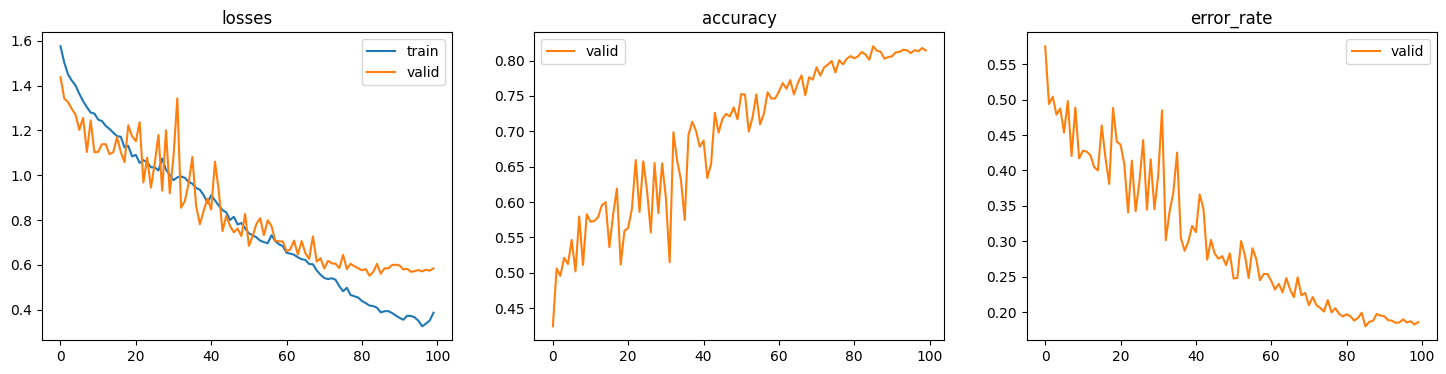

In [ ]:
learn.recorder.plot_metrics()

# Validation batch images

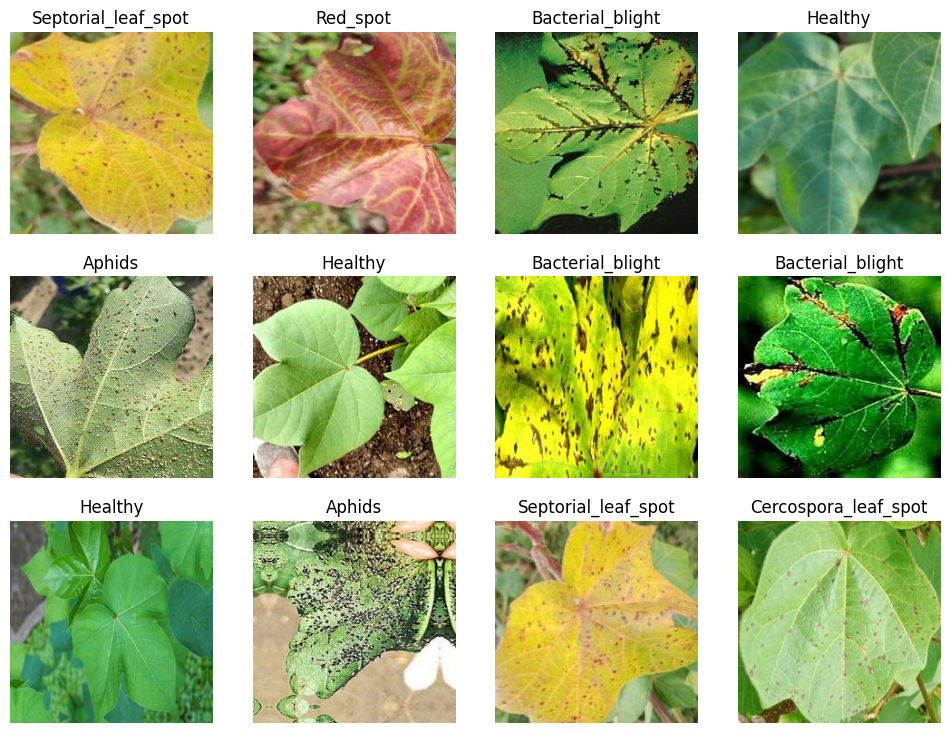

In [ ]:
dls.valid.show_batch(max_n=12, nrows=3)

# Perform predictions on the validation set

In [ ]:
# Perform predictions on the validation set
preds, targets = learn.get_preds(dl=dls.valid)

# Calculate evaluation metrics

In [ ]:
# Calculate evaluation metrics
pred_labels = preds.argmax(dim=1).cpu().numpy()
target_labels = targets.cpu().numpy()
accuracy = (pred_labels == target_labels).mean()
precision, recall, f1_score, _ = precision_recall_fscore_support(target_labels, pred_labels, average='weighted')
kappa = cohen_kappa_score(target_labels, pred_labels)

# Print the evaluation metrics

In [ ]:
# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Kappa: {kappa:.4f}")

Accuracy: 0.8143
Precision: 0.8248
Recall: 0.8143
F1 Score: 0.8180
Kappa: 0.7842


# Model Signature

In [ ]:
??vision_learner

# Confusion matrix

In [ ]:
from IPython.core.pylabtools import figsize
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

# Plot top losses

In [ ]:
interp.plot_top_losses(10, nrows=5, figsize=(20,6))

# Test single image

In [ ]:
img = PILImage.create('/content/drive/MyDrive/cotton/Army_worm/18.jpg')
pred = learn.predict(img)
print(pred)

('Army_worm', tensor(1), tensor([1.6299e-05, 9.9435e-01, 4.0191e-04, 5.2548e-05, 1.0549e-04, 4.9862e-03,
        8.2524e-05, 5.6616e-07]))


# Export trained model

In [ ]:
learn.export('/content/drive/MyDrive/efficientnetb0res_100epoch_FastAI-08122023.pkl')

# Download trained model - (only For Kaggle)

In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/cotton')

In [ ]:
pwd

'/content/drive/MyDrive/cotton'

In [ ]:
ls

97%_acc/    Bacterial_blight/      model_torchviz      Red_spot/
Aphids/     Cercospora_leaf_spot/  model_torchviz.png  Septorial_leaf_spot/
Army_worm/  Healthy/               Powdery_mildew/


In [ ]:
from IPython.display import FileLink
FileLink(r'/content/drive/MyDrive/efficientnetb0res_100epoch_FastAI-08122023.pkl')

/content/drive/MyDrive/efficientnetb0res_100epoch_FastAI-08122023.pkl